In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

In [2]:
train = pd.read_csv('/Users/yelyzaveta.yaroshchuk/Documents/Projects/Digital_Turbine/train_data.csv')
test = pd.read_csv('/Users/yelyzaveta.yaroshchuk/Documents/Projects/Digital_Turbine/test_data.csv')

# Data preparation

In [3]:
# Data analysis
# visualization - insights
# data cleaning - outliers..  reshape dimension  check duplicates 


In [136]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41586 entries, 0 to 41585
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   eventTimestamp            41586 non-null  int64  
 1   unitDisplayType           41586 non-null  object 
 2   brandName                 41586 non-null  object 
 3   bundleId                  41586 non-null  object 
 4   appVersion                41586 non-null  object 
 5   correctModelName          41586 non-null  object 
 6   countryCode               41580 non-null  object 
 7   deviceId                  41586 non-null  object 
 8   osAndVersion              41586 non-null  object 
 9   connectionType            41569 non-null  object 
 10  c1                        41586 non-null  object 
 11  c2                        41586 non-null  float64
 12  c3                        41586 non-null  object 
 13  c4                        41586 non-null  float64
 14  size  

In [5]:
train = train.drop_duplicates()
# There is no duplicates in train datasets

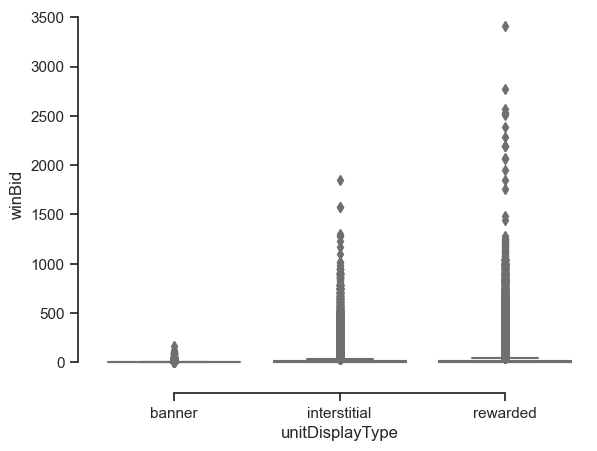

In [6]:
sns.set_theme(style="ticks", palette="pastel")


# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="unitDisplayType", y=train["winBid"],
             palette=["m", "g"],
            data=train)
sns.despine(offset=10, trim=True)

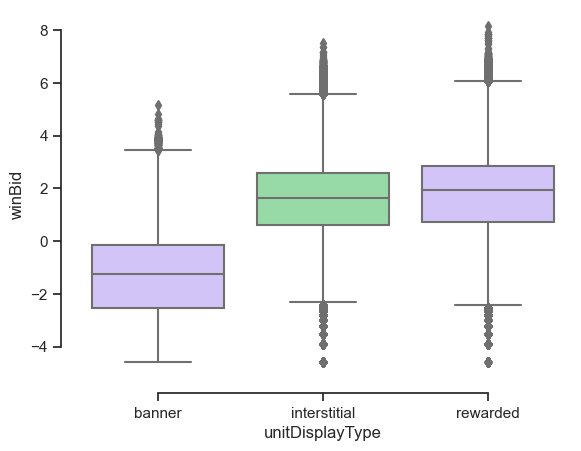

In [7]:
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="unitDisplayType", y=np.log(train["winBid"]),
             palette=["m", "g"],
            data=train)
sns.despine(offset=10, trim=True)

/Users/yelyzaveta.yaroshchuk/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


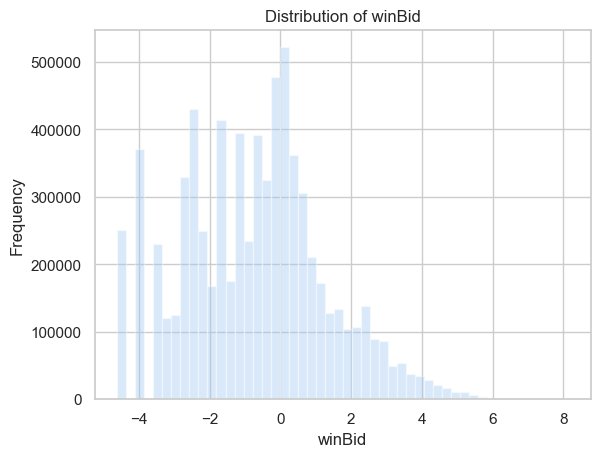

In [8]:


# Set the style for the plot (optional)
sns.set_style('whitegrid')

# Create a histogram of the winBid distribution
sns.distplot(np.log(train['winBid']), kde=False)

# Set plot labels and title
plt.xlabel('winBid')
plt.ylabel('Frequency')
plt.title('Distribution of winBid')

# Display the plot
plt.show()


In [3]:
df = train
df['diff'] = df['winBid'] - df['sentPrice']

In [4]:
# Group the data by 'unitDisplayType', 'size' and calculate the desired statistics

grouped_data = df.groupby(['unitDisplayType', 'size'])['winBid'].agg(['median', 'mean', 'std'])

# Calculate the 1st, 3rd quartiles, and add them to the grouped data
grouped_data['1st_Quartile'] = df.groupby(['unitDisplayType', 'size'])['winBid'].quantile(0.25)
grouped_data['3rd_Quartile'] = df.groupby(['unitDisplayType', 'size'])['winBid'].quantile(0.75)
grouped_data['has_won_percent'] = df.groupby(['unitDisplayType', 'size'])['has_won'].mean()
grouped_data['diff_mean'] = df.groupby(['unitDisplayType', 'size'])['diff'].mean()
grouped_data['diff_median'] = df.groupby(['unitDisplayType', 'size'])['diff'].median()
grouped_data['count'] = df.groupby(['unitDisplayType', 'size'])['diff'].count()


In [5]:
grouped_data  = grouped_data.reset_index().sort_values(by= 'median', ascending=False)
grouped_data

,unitDisplayType,size,median,mean,std,1st_Quartile,3rd_Quartile,has_won_percent,diff_mean,diff_median,count
8,rewarded,480x320,29.520,58.497833,58.892937,18.6100,69.1400,0.006192,54.654252,25.70,969
4,interstitial,480x320,23.560,36.911042,32.966828,15.9600,48.2500,0.000000,35.330653,20.78,873
2,interstitial,1024x768,10.275,17.300539,22.707411,5.8500,21.2175,0.026946,14.686557,8.20,334
6,rewarded,1024x768,9.990,15.645938,18.007336,4.3575,20.0000,0.047917,12.619146,6.74,480
9,rewarded,768x1024,8.080,17.095370,33.206284,2.9300,15.3300,0.032160,14.013927,5.33,81033
5,interstitial,768x1024,7.210,14.973466,29.025244,2.8600,15.0000,0.015679,12.651454,5.31,61420
7,rewarded,320x480,6.880,20.057508,49.120362,2.0400,17.5600,0.018065,17.189941,4.78,765772
3,interstitial,320x480,5.080,14.819796,35.229633,1.7400,13.0000,0.013551,13.123818,4.08,624977
1,banner,728x90,0.330,0.668080,1.127269,0.0900,0.9000,0.143583,0.518695,0.19,597514
0,banner,320x50,0.280,0.618789,0.900744,0.0800,0.8700,0.135069,0.520629,0.16,5188261


the mean is higher than the median in the context of the winBid column, it indicates that there are some high bid values that are pulling the mean upwards, resulting in a positively skewed distribution. This observation can be valuable when understanding the overall characteristics and behavior of the winBid data for different tyoe of ads.

In [6]:
train.columns

Index(['eventTimestamp', 'unitDisplayType', 'brandName', 'bundleId',
       'appVersion', 'correctModelName', 'countryCode', 'deviceId',
       'osAndVersion', 'connectionType', 'c1', 'c2', 'c3', 'c4', 'size',
       'mediationProviderVersion', 'bidFloorPrice', 'sentPrice', 'winBid',
       'has_won', 'diff'],
      dtype='object')

# Feature Engineering

 ideas:  add stats about one client  -   because maybe its a customer who buy and click onn advertisement 
        add column "expensive" for rewarded and interstitial display type for 480x320 size of ad
        keep banner dummy as cheap one
        

In [134]:
first_qt = np.log(train.winBid).quantile(0.25)
third_qt = np.log(train.winBid).quantile(0.75)


In [133]:
def feature_eng(df):
    df['high_price'] = np.where((df.unitDisplayType.isin([ 'rewarded', 'interstitial' ])) & (df["size"].isin(['480x320'])), 1, 0)
    df['winBid_raw'] = df['winBid']
    df['winBid'] = np.log(df['winBid'])
    
    gr_data_contry = df.groupby(['countryCode', 'brandName'])['winBid'].agg(['median'])
    gr_data_contry['high_segment'] = np.where(gr_data_contry['median'] > third_qt , 1, 0)
    gr_data_contry['middle_segment'] = np.where( (first_qt < gr_data_contry['median']) & (gr_data_contry['median']<= third_qt) , 1, 0)
    gr_data_contry = gr_data_contry.drop(columns = ['median'])
    df = pd.merge(df, gr_data_contry, on=['countryCode', 'brandName'], how='left')
    
    # Calculate the desired statistics for each unique combination
    
    stats = df.groupby(['deviceId', 'unitDisplayType', 'size'])['winBid'].agg(['mean', 'median'])

    # Rename the columns to reflect the statistics calculated
    stats.columns = ['mean_winBid', 'median_winBid']

    stats['1st_Quartile_winBid'] = df.groupby(['deviceId','unitDisplayType', 'size'])['winBid'].quantile(0.25)
    stats['3rd_Quartile_winBid'] = df.groupby(['deviceId','unitDisplayType', 'size'])['winBid'].quantile(0.75)

    # Reset the index to convert the grouped data back into a DataFrame
    stats = stats.reset_index()

    # Merge the statistics back into the main table based on the common columns
    df = pd.merge(df, stats, on=['deviceId', 'unitDisplayType', 'size'], how='left')
    # merged_df = pd.merge(merged_df, grouped_data[['unitDisplayType', 'size','median', 'mean', 'std', '1st_Quartile', '3rd_Quartile']], on=['unitDisplayType', 'size'], how='left')
    # merged_df = merged_df['mean_winBid'].fillna(merged_df['mean'])
    # merged_df = merged_df['median_winBid'].fillna(merged_df['median'])
    # merged_df = merged_df['1st_Quartile_winBid'].fillna(merged_df['1st_Quartile'])
    # merged_df = merged_df['3rd_Quartile_winBid'].fillna(merged_df['3rd_Quartile'])

    return (df)


dealing with categorical variable

In [10]:
categorical_cols = [ 'unitDisplayType', 'brandName', 'bundleId',
       'appVersion', 'correctModelName', 'countryCode', 
       'osAndVersion', 'connectionType', 'c1', 'c3','size',
       'mediationProviderVersion']
# for col in categorical_cols:
#     df[col] = df[col].astype('object')
    

In [12]:
def cat_dummy(df, max_freq)
# Define the maximum number of most frequent values to consider
max_freq_values = 2

# Iterate over each column in the DataFrame
for column in df[categorical_cols]:
    # Check if the column is categorical (dtype = 'object')
    if df[column].dtype == 'object':
        # Get the value counts for the column
        value_counts = df[column].value_counts()
        # Get the top most frequent values (up to max_freq_values)
        top_values = value_counts.head(max_freq_values).index.tolist()
        
        # Create dummy variables only for the top most frequent values
        for value in top_values:
            dummy_col_name = f"{column}_{value}"
            df[dummy_col_name] = (df[column] == value).astype(int)

        # Drop the original column
        df.drop(column, axis=1, inplace=True)

# Display the resulting DataFrame with dummy variables
# print(df)
    return df

# Modeling + Evaluation

In [121]:
df_rand = df.sample(n=500000, random_state=42)
df_rand[['high_segment','middle_segment']] = df_rand[['high_segment','middle_segment']].fillna(0).astype(int)

In [128]:
# the target variable is 'winBid', and the remaining columns are the features
# Split the data into training and testing sets
X = df_rand[['high_price'
            , 'high_segment'
             ,'middle_segment'
#              ,'median_winBid'
#              , '1st_Quartile_winBid'
#              , '3rd_Quartile_winBid'
              , 'unitDisplayType_banner',
       'unitDisplayType_rewarded', 'brandName_Generic', 'brandName_Samsung',
       'bundleId_com.loop.match3d', 'bundleId_1502447854',
       'appVersion_1245.35.0', 'appVersion_1245.34.0',
       'correctModelName_Android 4.0', 'correctModelName_iPhone',
       'countryCode_US', 'countryCode_GB', 'osAndVersion_Android-4.0',
       'osAndVersion_Android-11.0', 'connectionType_WIFI', 'connectionType_3G',
       'c1_7d3', 'c1_59b', 'c3_6b', 'c3_4b', 'size_320x50', 'size_320x480',
       'mediationProviderVersion_11.4.3', 'mediationProviderVersion_11.4.2'
                                                                                                               ]]
y = df_rand['winBid'].astype(float)
y = y.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [129]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# and the target variable is 'winBid', and the remaining columns are the feature
# Define the Random Forest model
model = RandomForestRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 1.1060797384197512


In [139]:
model_params = model.get_params()

# Print the model parameters
for param, value in model_params.items():
    print(param, ":", value)

bootstrap : True
ccp_alpha : 0.0
criterion : squared_error
max_depth : None
max_features : auto
max_leaf_nodes : None
max_samples : None
min_impurity_decrease : 0.0
min_samples_leaf : 1
min_samples_split : 2
min_weight_fraction_leaf : 0.0
n_estimators : 100
n_jobs : None
oob_score : False
random_state : None
verbose : 0
warm_start : False


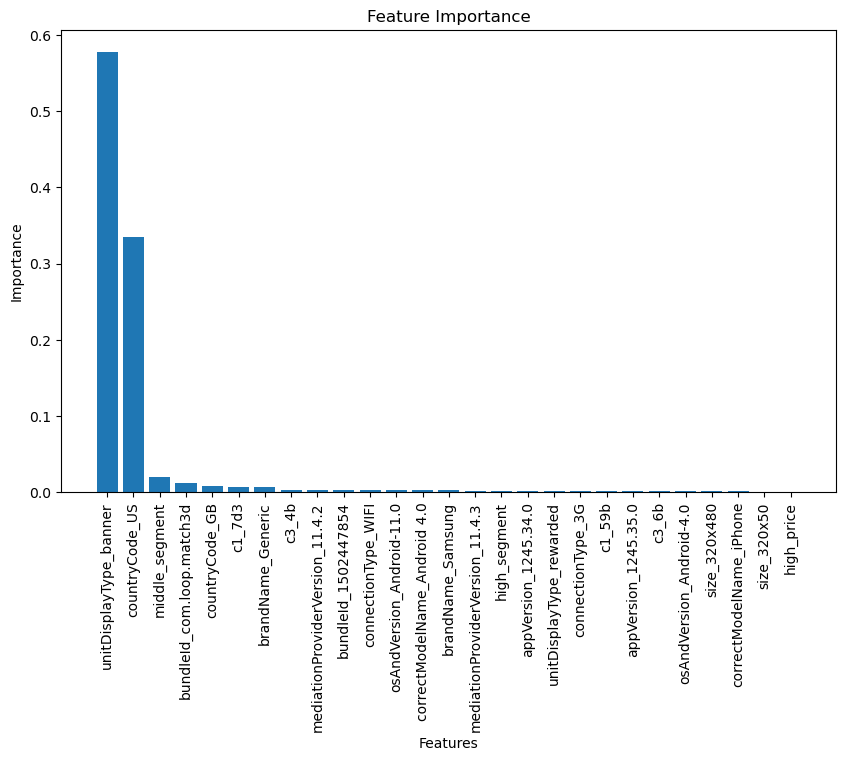

In [130]:
# Get the feature importances
importance = model.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

#### The models that Potentially could be used 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Create the Random Forest model
model = RandomForestRegressor()

# Define the hyperparameter grid for random search
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2,  10],
    'min_samples_leaf': [1, 3],
}

# Perform random search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42
)

# Fit the random search on the training data
random_search.fit(X, y)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)

# Use the best model for predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)


In [ ]:
# # Define the LightGBM model
# model = lgb.LGBMRegressor()

# # Define the hyperparameter grid for random search
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 200, 500],
#     'max_depth': [3, 5, 10],
#     'num_leaves': [20, 30, 40],
#     'min_child_samples': [10, 20, 30]
# }

# # Perform random search for hyperparameter tuning
# random_search = GridSearchCV(
#     estimator=model,
#     param_distributions=param_grid,
#     n_iter=10,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     random_state=42
# )

# # Fit the random search on the training data
# random_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])



/Users/yelyzaveta.yaroshchuk/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [ ]:
# # Print the best hyperparameters and corresponding score
# print("Best Hyperparameters:", random_search.best_params_)
# print("Best Score:", -random_search.best_score_)

# # Use the best model to make predictions on the test data
# best_model = random_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # Evaluate the model
# rmse = np.sqrt(np.mean((y_pred - y_test)**2))
# print("Root Mean Squared Error:", rmse)


In [ ]:
# import lightgbm as lgb

# # build the lightgbm model
# hyper_params = {
#     'task': 'train',
# #     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'learning_rate': 0.1,
#     # 'feature_fraction': .9,
#     # 'bagging_fraction': .7,
#     'bagging_freq': 10,
#     'verbose': 0,
#     "max_depth": 5,
#     "num_iterations": 100
# }
# lgb = lgb.LGBMRegressor(**hyper_params)

# lgb.fit(X_train, y_train,
#         eval_set=[(X_test, y_test)],
#         eval_metric='rmse',
#         early_stopping_rounds=10,)

/Users/yelyzaveta.yaroshchuk/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/yelyzaveta.yaroshchuk/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
# # Feature importance
# import matplotlib.pyplot as plt
# import seaborn as sns
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
# feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_,X_train.columns)), columns=['Value','Feature'])

# plt.figure(figsize=(20, 10))
# sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
# plt.title('LightGB Features')
# plt.tight_layout()
# plt.show()

In [60]:
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
# import xgboost as xgb
# import numpy as np

# # Define the XGBoost model
# model = xgb.XGBRegressor()

# # Define the hyperparameter grid for random search
# param_grid = {
#     'learning_rate': [0.01,  0.1],
#     'n_estimators': [100,  500],
#     'max_depth': [3, 7],
# #     'subsample': [0.6, 0.8, 1.0],
# #     'colsample_bytree': [0.6, 0.8, 1.0],
# #     'reg_alpha': [0, 0.1, 0.5],
# #     'reg_lambda': [0, 0.1, 0.5]
# }

# # Perform grid search for hyperparameter tuning
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',
#     cv=5
# )

# # Fit the grid search on the training data
# grid_search.fit(X_train, y_train)



KeyboardInterrupt: 

In [ ]:

# # Print the best hyperparameters and corresponding score
# print("Best Hyperparameters:", random_search.best_params_)
# print("Best Score:", -random_search.best_score_)

# # Use the best model to make predictions on the test data
# best_model = random_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # Evaluate the model
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print("Root Mean Squared Error:", rmse)
